In [35]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from IPython.display import clear_output
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
# Loading files
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [37]:
## Loading data from JSON
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        train_text.extend(dataf_text)
        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        train_labels.extend(dataf_labels)
    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [38]:
# Split the data into training, validation, testing sets.

from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train_tweets, val_documents, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [39]:
# Print example tweet
print(f'What does one instance look like from the training set? \n\n{train_tweets[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

Tesco criticised for 'disgraceful' advert showing domestic worker being slapped
...and here is its corresponding label 

0


# 1. Preprocessing using  lemmatization
We create a lemmatizer tokenizer that reduces words to their root forms. This reduces the vocabulary size.

In [40]:
# We create a lemmaTokenizer class that applies lemmatization when tokenizing.
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
    

# 2.1 Using bi-grams + unigrams as feature
We apply our tokenizer and set it to allow ngram features (both unigrams and bigrams). 

In [41]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train_tweets)
X_train = vectorizer.transform(train_tweets)
X_val = vectorizer.transform(val_documents)
X_test_tweets = vectorizer.transform(test_tweets)
# Let's look at some of the features.
print(list(vectorizer.vocabulary_)[:10])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['$', 'gnrc', 'find', 'support', 'at', 'it', '10-day', 'line', 'so', 'far']


In [42]:
# Checking full vocabulary size:
print(f' Full vocabulary size: {len(vectorizer.vocabulary_)}')
vocabulary = vectorizer.vocabulary_

 Full vocabulary size: 10749


              precision    recall  f1-score   support

           0       0.53      0.32      0.40        50
           1       0.40      0.13      0.20        31
           2       0.61      0.87      0.71        97

    accuracy                           0.58       178
   macro avg       0.51      0.44      0.44       178
weighted avg       0.55      0.58      0.54       178



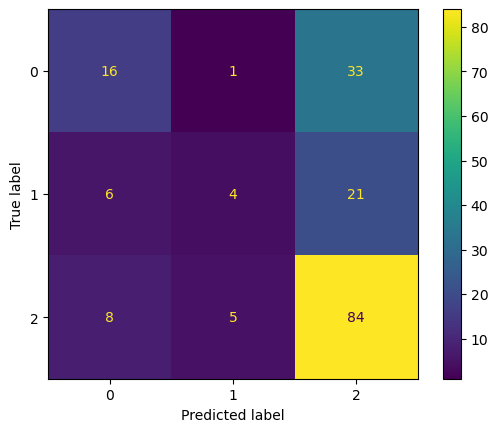

In [43]:
# Now let's fit our data to the model.
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

# Using POS-NEG lexicon features

In [44]:
# instantiate analyzer
analyser = SentimentIntensityAnalyzer()
# fetch vocabulary
vocabulary = vectorizer.vocabulary_
# create empy holders for lexicon scores.
lexicon_pos_scores = np.zeros((1, len(vocabulary)))
lexicon_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lexicon_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lexicon_neg_scores[0, i] = 1

In [45]:
# This enables us to get the total positive and total negative counts for each set:
lexicon_pos_train = np.sum(X_train.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_val = np.sum(X_val.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_test = np.sum(X_test_tweets.multiply(lexicon_pos_scores), axis=1)

lexicon_neg_train = np.sum(X_train.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_val = np.sum(X_val.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_test = np.sum(X_test_tweets.multiply(lexicon_neg_scores), axis=1)

In [46]:
X_train = hstack((X_train, lexicon_pos_train, lexicon_neg_train))
X_val = hstack((X_val, lexicon_pos_val, lexicon_neg_val))
X_test_tweets = hstack((X_test_tweets, lexicon_pos_test, lexicon_neg_test))

              precision    recall  f1-score   support

           0       0.53      0.32      0.40        50
           1       0.38      0.10      0.15        31
           2       0.61      0.88      0.72        97

    accuracy                           0.58       178
   macro avg       0.51      0.43      0.42       178
weighted avg       0.55      0.58      0.53       178



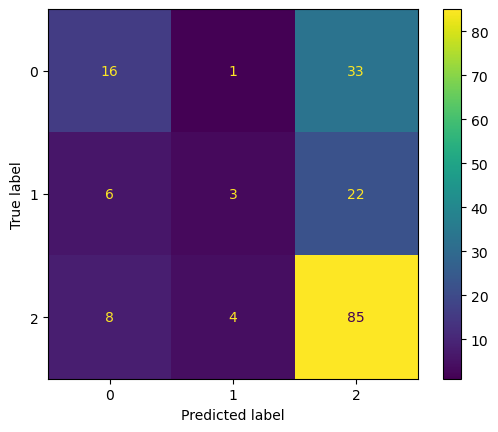

In [47]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [48]:
# Key part is investigating the errors by looking at the actual values, so let's do that:
error_indexes = y_val_pred != val_labels  # let's compare predictions to true values for labels

# get the tweets where the classifier made an error:
tweets_err = np.array(val_documents)[error_indexes]

pred_err = y_val_pred[error_indexes]
true_err = np.array(val_labels)[error_indexes]

for i in range(10):
    print(f'Tweet: {tweets_err[i]}; true label = {true_err[i]}, prediction = {pred_err[i]}.')

Tweet: Goodwin not to face Scottish prosecution over RBS; true label = 1, prediction = 0.
Tweet: CompaniesHoward Davies appointment as RBS director delayed; true label = 1, prediction = 0.
Tweet: Infection worries prompt regulatory reviews of Gilead leukaemia drug $GILD https://t.co/H9vqXpZ15G via @YahooFinance; true label = 0, prediction = 2.
Tweet: Keith Skeoch to step up as David Nish quits as chief executive of Standard Life; true label = 1, prediction = 2.
Tweet: $GOOG resistance turned support?  It; true label = 2, prediction = 1.
Tweet: Profit taking on $AAPL this morning?  That has to be the pressure on the stock.  I'm still bullish on $AAPL.; true label = 2, prediction = 1.
Tweet: Mylan Appoints Ranjan Ray Chaudhuri as Global Commercial Lead for Mylan's Over ...; true label = 1, prediction = 0.
Tweet: $GEVO PLUNGING!  Back to $3.55.; true label = 0, prediction = 2.
Tweet: $AAPL - Has broken its downtrend - but 200DMA proving to be stiff resistance short term. https://t.co/Vlzl

# Performance on test set

              precision    recall  f1-score   support

           0       0.76      0.52      0.62        62
           1       0.44      0.21      0.28        39
           2       0.69      0.92      0.79       122

    accuracy                           0.68       223
   macro avg       0.63      0.55      0.56       223
weighted avg       0.67      0.68      0.65       223



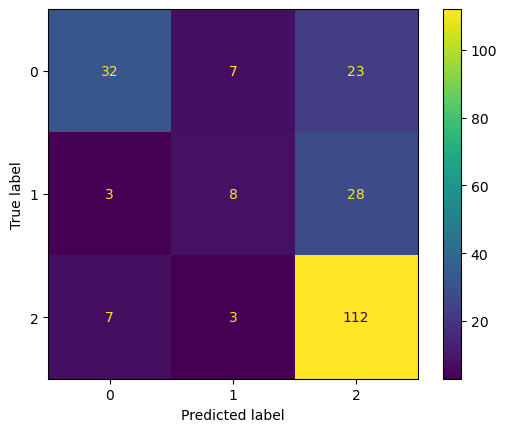

In [49]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test_tweets)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# 4. Extracting topics using LDA

In [50]:
# First let's get another clean split of the data. 
from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train_tweets, val_tweets, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels 
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_tweets)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [51]:
 # We use the function below for tokenization. Does a number of things, including removing small words, deleting words with special chars,  changing uppercase to lowercase, and more.
def preprocess(text):
    final_results=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            final_results.append(WordNetLemmatizer().lemmatize(token, 'v'))
    return final_results

# Create a list of preprocessed documents
processed = []
for doc in train_tweets:
    processed.append(preprocess(doc))
print(processed)

[['hammerson', 'jv', 'partner', 'secure', 'ownership', 'ireland', 'dundrum', 'quick', 'facts'], ['johnson', 'matthey', 'raise', 'prospect', 'investor', 'payout'], ['tsla', 'recall', 'big', 'deal', 'problem', 'excuse', 'guide', 'way', 'way', 'lower'], ['amazon', 'sell', 'surveillance', 'cameras', 'infect', 'malware', 'amzn', 'amazon', 'https', 'tohleq', 'fk', 'https', 'pr', 'cbtvvy'], ['tesla', 'model', 'deliveries', 'germany', 'record', 'deliveries', 'march', 'chart', 'https', 'ycnclcbimv', 'tsla'], ['sainsbury', 'asda', 'tesco', 'morrisons', 'cut', 'petrol', 'price', 'oil', 'fall'], ['rt', 'joemccann', 'correleation', 'dollar', 'index', 'spy', 'simply', 'amaze', 'dx', 'find', 'support', 'spy', 'retreat', 'like', 'clockwork'], ['ko', 'miss', 'earn', 'expectations', 'quarter', 'today', 'strong', 'result', 'come', 'major', 'surprise', 'http', 'stks', 'rhf'], ['european', 'share', 'plunge', 'roil', 'bhp', 'oil', 'hop', 'turn', 'ecb'], ['aapl', 'nice', 'rsi', 'bounce'], ['baird', 'like', '

In [52]:
from gensim.corpora import Dictionary
# create a dictionary of word<->id key/val pairs.
dictionary = Dictionary(processed) 
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2320 unique tokens: ['dundrum', 'facts', 'hammerson', 'ireland', 'jv']...)


In [53]:
# Getting means of thetas and training the LDA.

from gensim.matutils import any2sparse
from gensim.models import LdaModel

lda_model =  LdaModel(bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

def get_tweet_topic_dists(tweets, lda_model):
    thetas = []
    for i in range(len(tweets)):
        # Get the tweet
        unseen_tweet = tweets[i]

        # Preprocess for bag of words:
        bow_vector = dictionary.doc2bow(preprocess(unseen_tweet))

        # Let's get the topic distribution:
        theta_tweet = lda_model[bow_vector]

        thetas.append(theta_tweet)

    return thetas

thetas = get_tweet_topic_dists(val_tweets, lda_model)

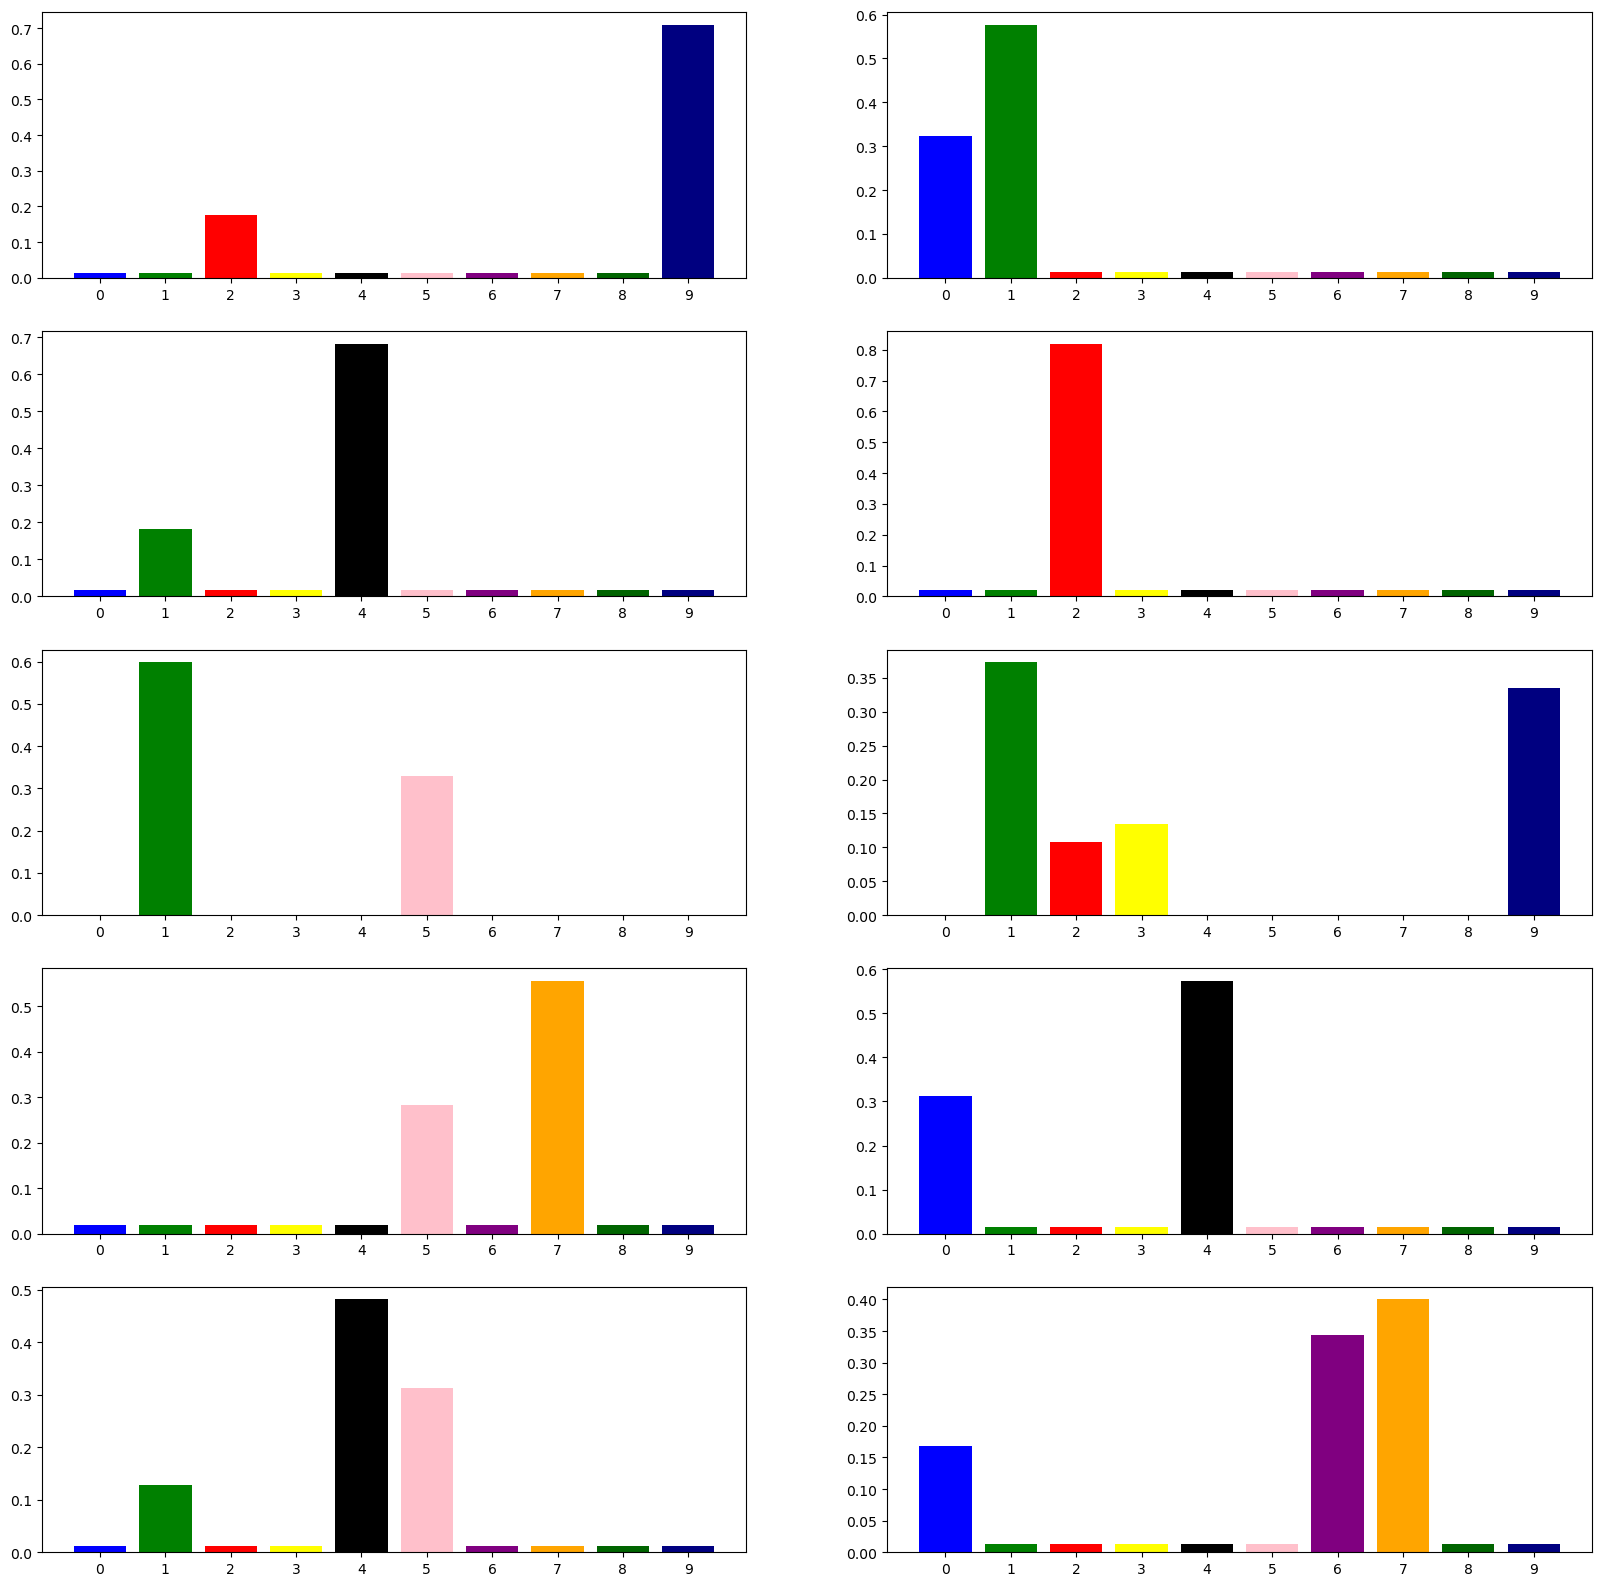

In [60]:

# We will use colours to represent topics.
colours = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple',
           'orange',  'darkgreen',  'navy', 'crimson']

def convert_theta_sparse_to_dense_vector(theta_dist_sparse, num_topics):
    theta_dist = np.zeros(num_topics)
    
    # get active topics
    active_topics_for_dist, probs = map(list, zip(*theta_dist_sparse))
    
    # add to thetas_dist
    for i, topic in enumerate(active_topics_for_dist):
        if topic >= num_topics:
            break
            
        theta_dist[topic] = probs[i]
    
    return theta_dist

# Create barchart
def plot_theta(thetas, i, num_tweets, num_topics):
    plt.subplot(int((num_tweets+1)/2), 2, i+1)
    theta_dist = convert_theta_sparse_to_dense_vector(thetas[i], num_topics)
    plt.bar(x=np.arange(len(theta_dist)), height=theta_dist, color=colours, tick_label=np.arange(num_topics))

plt.figure(figsize=(20,20))

num_tweets = 10
num_topics = 10
counter = 0
for i, theta in enumerate(thetas):
    if (counter < 10):
        plot_theta(thetas, i, num_tweets, num_topics)
        counter +=1
plt.show()

# Visualizing topic distributions across labels using validation set

In [55]:
# Merge arrays for later 
arr = val_tweets
arr_2 = val_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

[['NYSE owner ICE may gatecrash Deutsche Boerse-LSE merger' '1']
 ['AB InBev attacks SABMiller bid rebuffal' '1']
 ['$PAY 2nd time test of the 21.20-30 b/o zone.  Still not breaking out.  Moved my stop up to 20.80.'
  '1']
 ['AB InBev to sell more SAB assets as seeks EU deal approval' '1']
 ["My $DWA play up 6% today. I'm still skeptical. Will take profits. Not a time cheer"
  '1']
 ['Royal Mail turnaround proving expensive in tough UK market' '1']
 ['$RAD All my charts are flashing oversold.' '1']
 ['Barclays poised to replace Sir Mike Rake as he heads for exit' '1']
 ['$AAPL at pivot area on intraday chart- break here could send this to 50-day SMA, 457.80 http://stks.co/jPbN'
  '1']
 ['$GILD 91 now support. $IBB $BIB https://t.co/GIoOf6zbKv' '1']
 ["i-Grid shows $DIA capped for the long term at range of 123.40- 124.77;any rally beyond today's levels or into this range leads to meltdown."
  '1']
 ['$AAPL Action into the close indicates that $AAPL probably hit a near term high.  Moment

In [56]:
# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(val_tweets[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

print(mean_arr.shape)

[0.10137182 0.09347929 0.139119   0.07798098 0.04033486 0.08057836
 0.14682379 0.06999434 0.12949276 0.11558279]
[0.07332508 0.09340468 0.16514445 0.10297056 0.15536667 0.06192064
 0.06844884 0.06940765 0.05897752 0.14495087]
[0.13660436 0.12241188 0.09888053 0.06383776 0.06344235 0.08867418
 0.0877206  0.10115086 0.15914823 0.07370065]
(3, 10)


[0.10122858 0.09642941 0.13507935 0.07808065 0.04032627 0.08051717
 0.14742764 0.0699802  0.13457946 0.11110928]
[0.07961295 0.09343263 0.16015352 0.10766313 0.15736287 0.05806524
 0.06123676 0.07242303 0.05896873 0.14499815]
[0.13454476 0.12387025 0.09253357 0.07242184 0.06344266 0.0886676
 0.08494447 0.09511704 0.16650061 0.07352861]


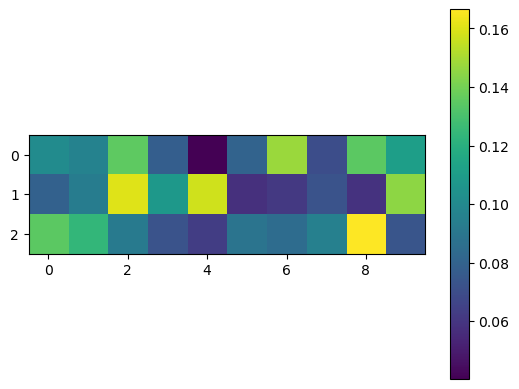

In [57]:
def plot_tweet_topic_matrix():
    # Get mean tweet topics dists
    mean_thetas = get_tweet_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.show()
plot_tweet_topic_matrix()

In [58]:
# For each topic, let's show the words occuring in that topic, so we can identify it.
for topic_id, topic in lda_model.print_topics(-1):
    print("Topic ID: {} \nAssociated Words:\n {}".format(topic_id, topic ))
    print("\n")

Topic ID: 0 
Associated Words:
 0.017*"astrazeneca" + 0.016*"share" + 0.012*"price" + 0.011*"https" + 0.011*"drug" + 0.009*"new" + 0.009*"look" + 0.008*"fall" + 0.008*"cancer" + 0.007*"dividend"


Topic ID: 1 
Associated Words:
 0.030*"http" + 0.027*"stks" + 0.009*"point" + 0.008*"buy" + 0.007*"long" + 0.007*"chart" + 0.006*"https" + 0.006*"aapl" + 0.006*"stock" + 0.006*"support"


Topic ID: 2 
Associated Words:
 0.025*"https" + 0.016*"tsla" + 0.014*"tesla" + 0.013*"recall" + 0.011*"model" + 0.008*"http" + 0.008*"stock" + 0.007*"stks" + 0.007*"tesco" + 0.007*"rise"


Topic ID: 3 
Associated Words:
 0.010*"market" + 0.008*"https" + 0.008*"http" + 0.008*"stks" + 0.008*"today" + 0.007*"good" + 0.007*"buy" + 0.007*"report" + 0.006*"price" + 0.006*"share"


Topic ID: 4 
Associated Words:
 0.020*"plc" + 0.013*"http" + 0.013*"stks" + 0.011*"short" + 0.008*"look" + 0.007*"group" + 0.007*"stock" + 0.007*"good" + 0.007*"great" + 0.005*"inbev"


Topic ID: 5 
Associated Words:
 0.015*"tsla" + 0.00

# Using test set

[['Tesco set to sell Kipa, Giraffe businesses - Sky News' '1']
 ['$TRIP maintains Neutral rating at JP Morgan- PT cut $61 from $66' '1']
 ['Facebook, near a buy point last week, faces a different technical test today https://t.co/c72LLMpiNM $FB $AAPL $NFLX https://t.co/fPFbYTYPuY'
  '1']
 ["Tesco closes in on new chairman with Dixons Carphone's John Allan in the frame"
  '1']
 ['easyJet expects resilient demand to withstand security fears' '1']
 ["AB InBev's Latest Bid Said Unlikely to Win SABMiller's Approval" '1']
 ['CEOs of BPM, UBI meet Italy econ minister as M&A talk heats up' '1']
 ['Goodwin not to face Scottish prosecution over RBS' '1']
 ['$vxx starting to creep up while $spy sits near hod ...' '1']
 ["Barclays appoints JPMorgan's Paul Compton as new COO" '1']
 ['Coke dividend - 3%. Google dividend - 0%. For passive income Coke takes it. $GOOG $KO https://t.co/QBsoWjxOST'
  '1']
 ['RT @StockTwits RT @fallondpicks Breadth Consolidates: After weeks of steady gains,advances in mkt

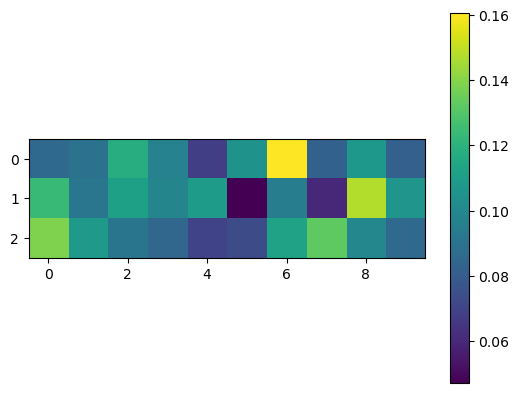

In [59]:
# Merge arrays for later 
arr = test_tweets
arr_2 = test_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(test_tweets[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

def plot_tweet_topic_matrix():
    # Get mean tweet topics dists
    mean_thetas = get_tweet_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.show()
plot_tweet_topic_matrix()